Big Data Project

Group id

section 63s

 Leen Alharbi            444008739

Baylasan Almuqati       444008690

Noura Albarrak          444008746

Lina Aljasir            444008726

In [ ]:
#1.importing required libraries.

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, to_date ,col ,sum , when
from google.colab import drive
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg

In [ ]:
#2.reaching google drive to upload the file
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#4.unzip the file
!unzip "/content/drive/My Drive/pmdata.zip" -d /content/pmdata

Archive:  /content/drive/My Drive/pmdata.zip
replace /content/pmdata/participant-overview.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/pmdata/participant-overview.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/pmdata/participant-overview.xlsx  
  inflating: /content/pmdata/p16/fitbit/heart_rate.json  
  inflating: /content/pmdata/p16/fitbit/calories.json  
  inflating: /content/pmdata/p16/fitbit/distance.json  
  inflating: /content/pmdata/p16/fitbit/exercise.json  
  inflating: /content/pmdata/p16/fitbit/lightly_active_minutes.json  
  inflating: /content/pmdata/p16/fitbit/moderately_active_minutes.json  
  inflating: /content/pmdata/p16/fitbit/resting_heart_rate.json  
  inflating: /content/pmdata/p16/fitbit/sedentary_minutes.json  
  inflating: /content/pmdata/p16/fitbit/sleep_score.csv  
  inflating: /content/pmdata/p16/fitbit/steps.json  
  inflating: /content/pmdata/p16/fitbit/sleep.json  
  inflating: /content/p

In [ ]:
#5.checking that all files were extracted
import os
os.listdir("/content/pmdata")

['p01',
 'p14',
 'p07',
 'p09',
 'p15',
 'participant-overview.xlsx',
 'p10',
 'p16',
 'p08',
 'p12',
 'p03',
 'p11',
 'p13',
 'p04',
 'p02',
 'p05',
 'p06']

In [ ]:
# 6.Start Spark Session
spark = SparkSession.builder.appName("MergePMData_TeacherStyle").getOrCreate()

In [ ]:
# 7.Define base path and file paths to merge
base_path = "/content/pmdata"
file_paths = {
    "sleep": ["fitbit", "sleep_score.csv"],
    "wellness": ["pmsys", "wellness.csv"],
    "injury": ["pmsys", "injury.csv"],
    "srpe": ["pmsys", "srpe.csv"],
}

In [ ]:
#8.Merge files and add participant_id
merged_dfs = {}  # This will hold the final merged data for each file

# Go through each file we want to merge
for name, rel_path in file_paths.items():
    dfs = []  # This will store data from all participants for this file

    # Go through each participant folder
    for pid in os.listdir(base_path):
        # Build the path to the specific file
        full_path = os.path.join(base_path, pid, *rel_path)

        # Only read the file if it actually exists
        if os.path.exists(full_path):
            # Read the file into a Spark DataFrame
            df = spark.read.option("header", True).option("inferSchema", True).csv(full_path)

            # Add a column to know which participant this data belongs to
            df = df.withColumn("participant_id", lit(pid))

            # Add this participant's data to the list
            dfs.append(df)

    # Once all participant files are read, merge them into one DataFrame
    if dfs:
        merged_df = dfs[0]  # Start with the first one
        for df in dfs[1:]:  # Add the rest
            merged_df = merged_df.unionByName(df)

        # Save the merged result for this file (like sleep or wellness)
        merged_dfs[name] = merged_df


In [ ]:
#9.Rename date-related columns to "Date" so that they align for joining
# Sleep
if "sleep" in merged_dfs and "timestamp" in merged_dfs["sleep"].columns:
    merged_dfs["sleep"] = merged_dfs["sleep"].withColumnRenamed("timestamp", "Date")

# Wellness
if "wellness" in merged_dfs and "effective_time_frame" in merged_dfs["wellness"].columns:
    merged_dfs["wellness"] = merged_dfs["wellness"].withColumnRenamed("effective_time_frame", "Date")

# SRPE
if "srpe" in merged_dfs and "end_date_time" in merged_dfs["srpe"].columns:
    merged_dfs["srpe"] = merged_dfs["srpe"].withColumnRenamed("end_date_time", "Date")

# Injury
if "injury" in merged_dfs and "effective_time_frame" in merged_dfs["injury"].columns:
    merged_dfs["injury"] = merged_dfs["injury"].withColumnRenamed("effective_time_frame", "Date")


In [ ]:
#10.Extract only the date part (remove time)
for key in merged_dfs:
    if "Date" in merged_dfs[key].columns:
        merged_dfs[key] = merged_dfs[key].withColumn("Date", to_date("Date"))

In [ ]:
#11.Perform INNER JOIN on participant_id and Date
# Start with sleep and wellness
df_final = merged_dfs["sleep"].join(merged_dfs["wellness"], on=["participant_id", "Date"], how="inner")

# Then join srpe
if "srpe" in merged_dfs:
 df_final = df_final.join(merged_dfs["srpe"], on=["participant_id", "Date"], how="left")

# Then join injury
if "injury" in merged_dfs:
    df_final = df_final.join(merged_dfs["injury"], on=["participant_id", "Date"], how="left")



# **Cleaning Data**

In [ ]:
#12.Drop duplicates
df_final = df_final.dropDuplicates()

In [ ]:
#Count the number of missing values per column
for col in df_final.columns:
   print(col.ljust(20), df_final.filter(df_final[col].isNull()).count())

participant_id       0
Date                 0
sleep_log_entry_id   0
overall_score        0
composition_score    0
revitalization_score 0
duration_score       0
deep_sleep_in_minutes 0
resting_heart_rate   0
restlessness         0
fatigue              0
mood                 0
readiness            0
sleep_duration_h     0
sleep_quality        0
soreness             0
soreness_area        0
stress               0
activity_names       913
perceived_exertion   923
duration_min         923
injuries             1378


In [ ]:
#13.Handle missing values
df_final = df_final.fillna("Unknown")

In [ ]:
 #14.Save final dataset to CSV

 # if it's your first time performung the code perform this
 #df_final.write.option("header", True).csv("/content/combined_dataset.csv")

 #otherwise this code
df_final.write.mode("overwrite").option("header", True).csv("/content/combined_dataset.csv")

In [ ]:
#15.Show result
df_final.show(10)

+--------------+----------+------------------+-------------+-----------------+--------------------+--------------+---------------------+------------------+--------------------+-------+----+---------+----------------+-------------+--------+--------------------+------+--------------------+------------------+------------+--------------------+
|participant_id|      Date|sleep_log_entry_id|overall_score|composition_score|revitalization_score|duration_score|deep_sleep_in_minutes|resting_heart_rate|        restlessness|fatigue|mood|readiness|sleep_duration_h|sleep_quality|soreness|       soreness_area|stress|      activity_names|perceived_exertion|duration_min|            injuries|
+--------------+----------+------------------+-------------+-----------------+--------------------+--------------+---------------------+------------------+--------------------+-------+----+---------+----------------+-------------+--------+--------------------+------+--------------------+------------------+---------

In [ ]:
# user only record when they are injured
from pyspark.sql.functions import when, col

df_final = df_final.withColumn(
    "injuries",
    when(col("injuries").isNull() | (col("injuries") == "Unknown"), "No Injury")
    .otherwise(col("injuries"))
)


## **EDA**

In [ ]:
#16.Count Rows and Columns
print('Number of rows: \t', df_final.count())
print('Number of columns: \t', len(df_final.columns))

Number of rows: 	 1521
Number of columns: 	 22


In [ ]:
#17.Coulmns names
df_final.columns

['participant_id',
 'Date',
 'sleep_log_entry_id',
 'overall_score',
 'composition_score',
 'revitalization_score',
 'duration_score',
 'deep_sleep_in_minutes',
 'resting_heart_rate',
 'restlessness',
 'fatigue',
 'mood',
 'readiness',
 'sleep_duration_h',
 'sleep_quality',
 'soreness',
 'soreness_area',
 'stress',
 'activity_names',
 'perceived_exertion',
 'duration_min',
 'injuries']

In [ ]:
#column types
df_final.dtypes

[('participant_id', 'string'),
 ('Date', 'date'),
 ('sleep_log_entry_id', 'bigint'),
 ('overall_score', 'int'),
 ('composition_score', 'int'),
 ('revitalization_score', 'int'),
 ('duration_score', 'int'),
 ('deep_sleep_in_minutes', 'int'),
 ('resting_heart_rate', 'int'),
 ('restlessness', 'double'),
 ('fatigue', 'int'),
 ('mood', 'int'),
 ('readiness', 'int'),
 ('sleep_duration_h', 'int'),
 ('sleep_quality', 'int'),
 ('soreness', 'int'),
 ('soreness_area', 'string'),
 ('stress', 'int'),
 ('activity_names', 'string'),
 ('perceived_exertion', 'string'),
 ('duration_min', 'string'),
 ('injuries', 'string')]

In [ ]:
#18.show participants id in increasing order
df_final.select("participant_id").distinct().orderBy("participant_id").show()

+--------------+
|participant_id|
+--------------+
|           p01|
|           p02|
|           p03|
|           p04|
|           p05|
|           p06|
|           p07|
|           p08|
|           p09|
|           p10|
|           p11|
|           p12|
|           p13|
|           p14|
|           p15|
|           p16|
+--------------+



In [ ]:
#19 Display schema and first few rows
df_final.printSchema()
df_final.orderBy("participant_id").show(5)

root
 |-- participant_id: string (nullable = false)
 |-- Date: date (nullable = true)
 |-- sleep_log_entry_id: long (nullable = true)
 |-- overall_score: integer (nullable = true)
 |-- composition_score: integer (nullable = true)
 |-- revitalization_score: integer (nullable = true)
 |-- duration_score: integer (nullable = true)
 |-- deep_sleep_in_minutes: integer (nullable = true)
 |-- resting_heart_rate: integer (nullable = true)
 |-- restlessness: double (nullable = true)
 |-- fatigue: integer (nullable = true)
 |-- mood: integer (nullable = true)
 |-- readiness: integer (nullable = true)
 |-- sleep_duration_h: integer (nullable = true)
 |-- sleep_quality: integer (nullable = true)
 |-- soreness: integer (nullable = true)
 |-- soreness_area: string (nullable = false)
 |-- stress: integer (nullable = true)
 |-- activity_names: string (nullable = false)
 |-- perceived_exertion: string (nullable = false)
 |-- duration_min: string (nullable = false)
 |-- injuries: string (nullable = fals

In [ ]:
#20 Summary statistics for numerical features
df_final.describe().show()

+-------+--------------+-------------------+------------------+------------------+--------------------+------------------+---------------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+--------------------+------------------+------------------+---------+
|summary|participant_id| sleep_log_entry_id|     overall_score| composition_score|revitalization_score|    duration_score|deep_sleep_in_minutes|resting_heart_rate|        restlessness|          fatigue|              mood|         readiness|  sleep_duration_h|     sleep_quality|          soreness|       soreness_area|           stress|      activity_names|perceived_exertion|      duration_min| injuries|
+-------+--------------+-------------------+------------------+------------------+--------------------+------------------+---------------------+------------------+--------------------+----

In [ ]:
#21 Checking the number of missing values per column after cleaning
missing_values = df_final.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_final.columns])
missing_values.show()

+--------------+----+------------------+-------------+-----------------+--------------------+--------------+---------------------+------------------+------------+-------+----+---------+----------------+-------------+--------+-------------+------+--------------+------------------+------------+--------+
|participant_id|Date|sleep_log_entry_id|overall_score|composition_score|revitalization_score|duration_score|deep_sleep_in_minutes|resting_heart_rate|restlessness|fatigue|mood|readiness|sleep_duration_h|sleep_quality|soreness|soreness_area|stress|activity_names|perceived_exertion|duration_min|injuries|
+--------------+----+------------------+-------------+-----------------+--------------------+--------------+---------------------+------------------+------------+-------+----+---------+----------------+-------------+--------+-------------+------+--------------+------------------+------------+--------+
|             0|   0|                 0|            0|                0|                   

In [ ]:
# For columns like sleep_quality, soreness, and stress, ensure values are between 1 and 5:
valid_range = (col("sleep_quality") >= 1) & (col("sleep_quality") <= 5)
df_valid_sleep_quality = df_final.filter(valid_range)

valid_range_soreness = (col("soreness") >= 1) & (col("soreness") <= 5)
df_valid_soreness = df_final.filter(valid_range_soreness)

valid_range_stress = (col("stress") >= 1) & (col("stress") <= 5)
df_valid_stress = df_final.filter(valid_range_stress)

# You can check the counts to see how many records fall outside the expected range:
invalid_sleep_quality = df_final.filter(~valid_range).count()
invalid_soreness = df_final.filter(~valid_range_soreness).count()
invalid_stress = df_final.filter(~valid_range_stress).count()

df_final = df_final.filter(valid_range & valid_range_soreness & valid_range_stress)

print("Invalid sleep_quality count:", invalid_sleep_quality)
print("Invalid soreness count:", invalid_soreness)
print("Invalid stress count:", invalid_stress)

Invalid sleep_quality count: 2
Invalid soreness count: 2
Invalid stress count: 3


# Visualisation

In [ ]:
#22 corelation heatmap
# Convert Spark DataFrame to Pandas
df_final_pd = df_final.toPandas()
# Keep only numeric columns (exclude strings like 'participant_id')
numeric_df = df_final_pd.select_dtypes(include=["number"])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Show the correlation matrix
print(correlation_matrix)


                       sleep_log_entry_id  overall_score  composition_score  \
sleep_log_entry_id               1.000000       0.068605           0.005163   
overall_score                    0.068605       1.000000           0.624558   
composition_score                0.005163       0.624558           1.000000   
revitalization_score             0.026992       0.585504           0.156826   
duration_score                   0.084500       0.835585           0.363730   
deep_sleep_in_minutes            0.005267       0.492308           0.520098   
resting_heart_rate              -0.000039       0.109967           0.108986   
restlessness                    -0.045448      -0.332134          -0.093403   
fatigue                          0.063560       0.175891           0.077277   
mood                             0.030865       0.130439           0.020835   
readiness                        0.025543       0.031319          -0.096135   
sleep_duration_h                 0.053435       0.47

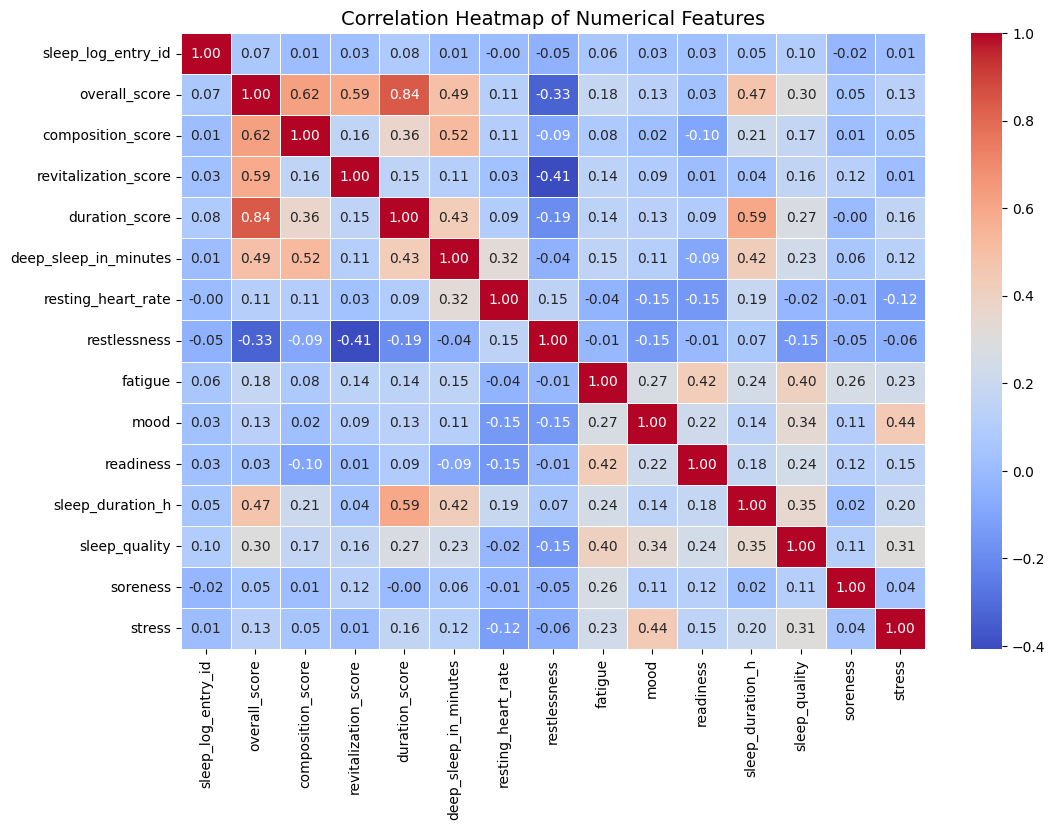

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)

# Display the plot
plt.show()

### **Overall Sleep Score:**

Duration (0.84) and Composition (0.62) are the strongest drivers of overall sleep quality, emphasizing that longer sleep and a balanced distribution of sleep stages are critical.

Deep Sleep:

Moderately correlated with overall quality (≈0.49) and duration (≈0.42), indicating it contributes significantly but isn’t the sole factor.

Restlessness:

Shows a moderate negative impact on overall sleep quality (≈–0.33) and a strong negative relationship with revitalization (≈–0.41), highlighting that higher restlessness detracts from a refreshing sleep.

Subjective Measures (Readiness, Revitalization):

These have relatively weak correlations with the objective sleep metrics, suggesting that how refreshed participants feel may be influenced by additional external factors.

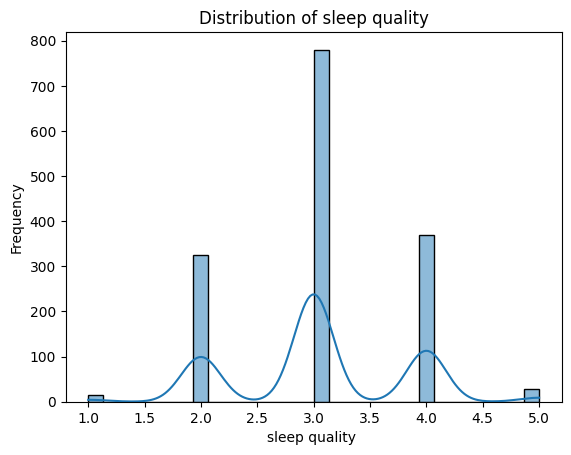

In [ ]:
#23 Histogram to show distribution of selected features
sns.histplot(df_final_pd["sleep_quality"], bins=30, kde=True)
plt.title("Distribution of sleep quality")
plt.xlabel("sleep quality ")
plt.ylabel("Frequency")
plt.show()

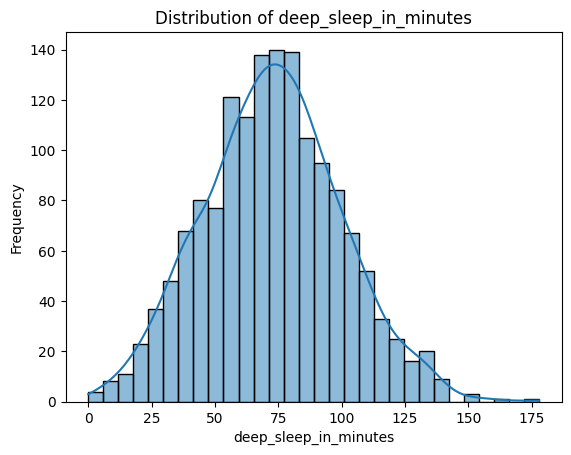

In [ ]:
sns.histplot(df_final_pd["deep_sleep_in_minutes"], bins=30, kde=True)
plt.title("Distribution of deep_sleep_in_minutes")
plt.xlabel("deep_sleep_in_minutes")
plt.ylabel("Frequency")
plt.show()

The histogram reveals that around **75** minutes was the most frequently reported sleep duration among participants

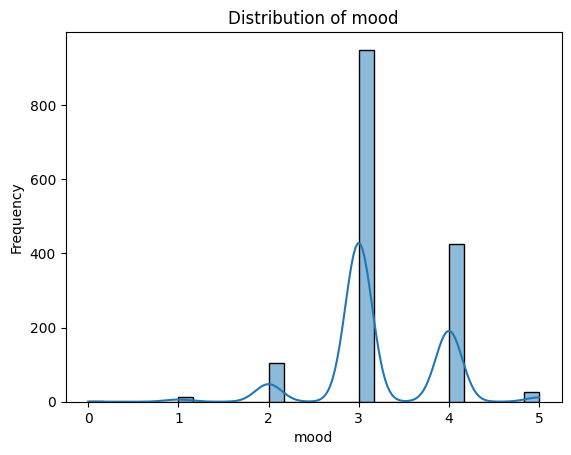

In [ ]:
sns.histplot(df_final_pd["mood"], bins=30, kde=True)
plt.title("Distribution of mood")
plt.xlabel("mood")
plt.ylabel("Frequency")
plt.show()


**As we can see in here the unimodal distribution centered at the higher end indicates that most participants report a relatively positive mood**

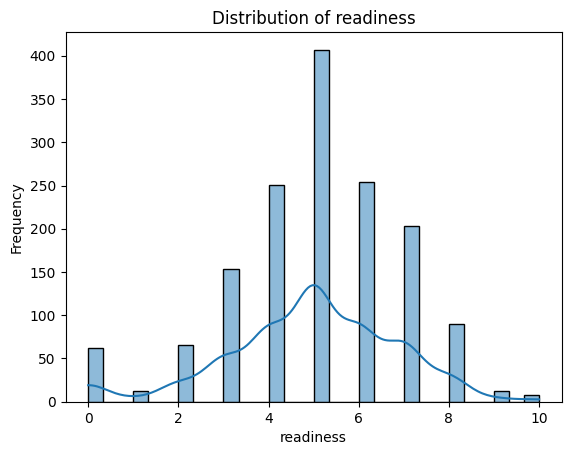

In [ ]:
sns.histplot(df_final_pd["readiness"], bins=30, kde=True)
plt.title("Distribution of readiness")
plt.xlabel("readiness")
plt.ylabel("Frequency")
plt.show()

**The readiness histogram suggests that participants typically rate themselves in the moderate-to-high range (5–7), with some outliers at both extremes (0–1 and 9–10). While the data is somewhat clustered, the broad coverage across 0–10 indicates that readiness is a variable metric, which could be valuable for understanding individual differences in performance and well-being.**

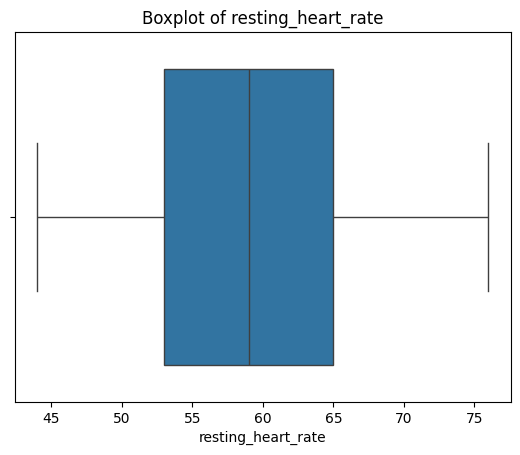

In [ ]:
#24 Boxplot for a numerical feature (e.g., resting_heart_rate) to detect outliers
sns.boxplot(x=df_final_pd["resting_heart_rate"])
plt.title("Boxplot of resting_heart_rate")
plt.show()

**The boxplot indicates that most participants have resting heart rates in a healthy, with few outliers. This stable distribution may reduce the variables direct impact on predictive models but remains a useful baseline measure for overall health.**

<ipython-input-95-7386d25b3f8a>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Performance Class")


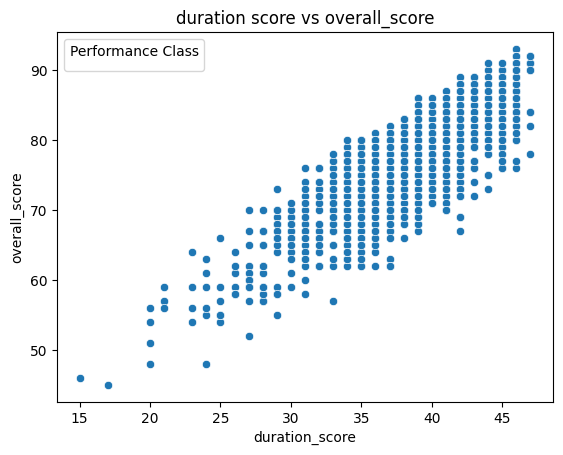

In [ ]:
#25 Scatter plot to see relationship between two features
sns.scatterplot(x=df_final_pd["duration_score"], y=df_final_pd["overall_score"])
plt.title("duration score vs overall_score")
plt.xlabel("duration_score")
plt.ylabel("overall_score")
plt.legend(title="Performance Class")
plt.show()

**the scatter plot demonstrates a robust, positive relationship between total sleep duration and overall sleep quality.Participants who sleep longer tend to have higher overall sleep scores, showing that sleep duration is important for better sleep quality.**

<ipython-input-96-b6ce72ea28cc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="overall_score_str", data=df_final_pd, palette="viridis", order=sorted(df_final_pd["overall_score_str"].unique()))


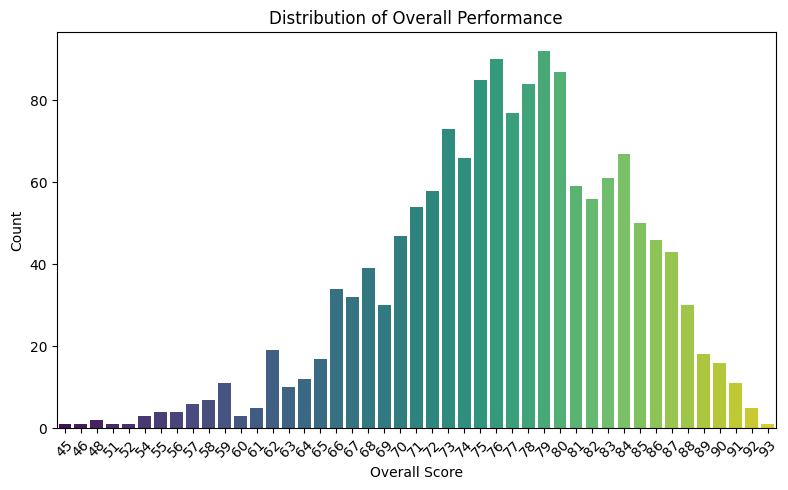

In [ ]:
# Convert overall_score to string to treat it as a categorical variable
df_final_pd["overall_score_str"] = df_final_pd["overall_score"].astype(str)

plt.figure(figsize=(8,5))
ax = sns.countplot(x="overall_score_str", data=df_final_pd, palette="viridis", order=sorted(df_final_pd["overall_score_str"].unique()))
ax.set_xlabel("Overall Score")
ax.set_ylabel("Count")
ax.set_title("Distribution of Overall Performance")

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**The bar chart reveals that overall_score is heavily concentrated around moderate-to-high values, with fewer participants at the extremes. This distribution suggests a mostly consistent performance level across the sample, offering a solid baseline for further modeling and segmentation.**

In [ ]:
# Count training sessions per participant
df_final.groupBy("participant_id").count().selectExpr("participant_id", "count as training_sessions").show()

+--------------+-----------------+
|participant_id|training_sessions|
+--------------+-----------------+
|           p03|               46|
|           p13|               32|
|           p07|              135|
|           p09|               92|
|           p01|              140|
|           p06|              144|
|           p02|              101|
|           p12|                1|
|           p11|              110|
|           p10|               82|
|           p08|              100|
|           p16|               82|
|           p14|              108|
|           p05|              106|
|           p15|              102|
|           p04|              137|
+--------------+-----------------+



In [ ]:
#count training Sessions per Participant
df_final.groupBy("participant_id").count().orderBy("count", ascending=False).show()

+--------------+-----+
|participant_id|count|
+--------------+-----+
|           p06|  144|
|           p01|  140|
|           p04|  137|
|           p07|  135|
|           p11|  110|
|           p14|  108|
|           p05|  106|
|           p15|  102|
|           p02|  101|
|           p08|  100|
|           p09|   92|
|           p10|   82|
|           p16|   82|
|           p03|   46|
|           p13|   32|
|           p12|    1|
+--------------+-----+



In [ ]:
# count how many times participant got injurd
#هذا الكود خطا
#injury_counts.groupBy("participant_id").count().orderBy("count", ascending=False).show()

In [ ]:
# count average sleeping hours for each participant
df_final.groupBy("participant_id") \
    .agg(avg(col("sleep_duration_h")).alias("avg_sleep_hours")) \
    .orderBy("avg_sleep_hours", ascending=False) \
    .show()

+--------------+------------------+
|participant_id|   avg_sleep_hours|
+--------------+------------------+
|           p14| 8.157407407407407|
|           p15| 7.637254901960785|
|           p08|              7.44|
|           p07|7.2518518518518515|
|           p10|7.2439024390243905|
|           p04| 6.883211678832117|
|           p11| 6.881818181818182|
|           p13|           6.84375|
|           p03| 6.826086956521739|
|           p09| 6.684782608695652|
|           p16| 6.670731707317073|
|           p02| 6.455445544554456|
|           p06| 6.069444444444445|
|           p12|               6.0|
|           p05| 5.566037735849057|
|           p01|               5.5|
+--------------+------------------+



In [ ]:
df_final_pd['readiness'].value_counts()

,count
readiness,
5,407
6,254
4,251
7,203
3,153
8,90
2,66
0,62
1,12


In [ ]:
#Convert class label [readiness] to becategorical

bins = [0, 4, 7, 10]  # Define the ranges  0 = Low (0–4), 1 = Medium (5–7), 2 = High (8–10)
labels = [0,1,2]

df_final_pd['readiness'] = pd.cut(df_final_pd['readiness'], bins=bins, labels=labels, right=True)
df_final_pd['readiness'].value_counts()

,count
readiness,
1,864
0,482
2,110


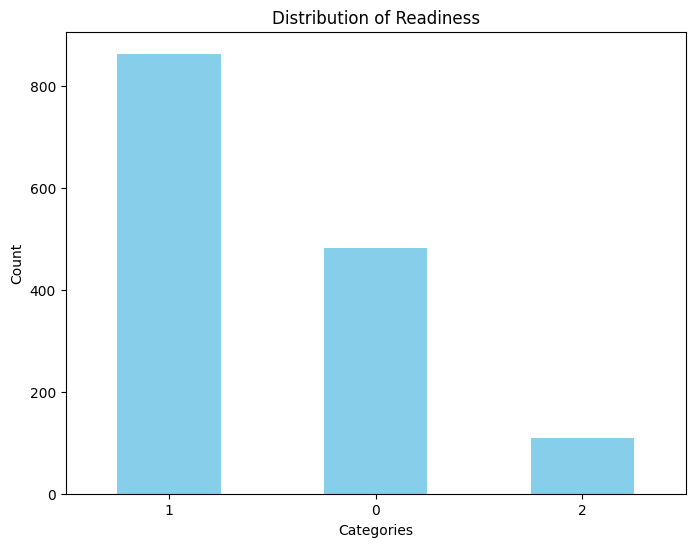

In [ ]:
plt.figure(figsize=(8, 6))
df_final_pd['readiness'].value_counts().plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Distribution of Readiness')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

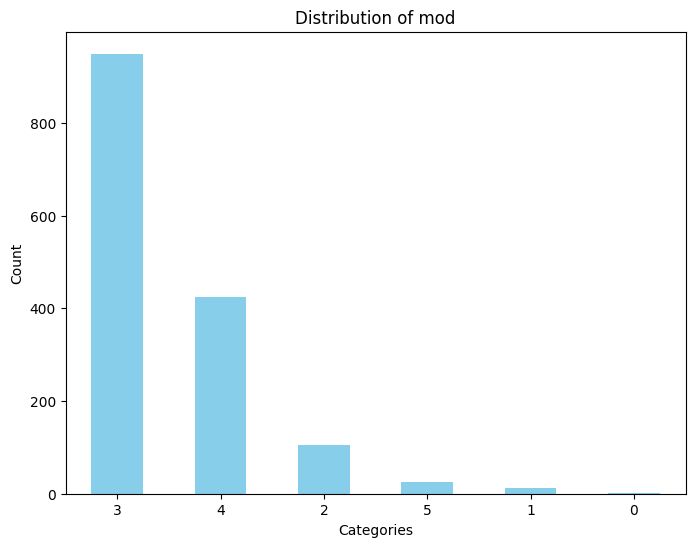

In [ ]:
plt.figure(figsize=(8, 6))
df_final_pd['mood'].value_counts().plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Distribution of mod')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [ ]:
#count the values for target column
readiness_counts = df_final.groupBy('readiness').count()
readiness_counts.show()

+---------+-----+
|readiness|count|
+---------+-----+
|        1|   12|
|        6|  254|
|        3|  153|
|        5|  407|
|        9|   12|
|        4|  251|
|        8|   90|
|        7|  203|
|       10|    8|
|        2|   66|
|        0|   62|
+---------+-----+



In [ ]:
from pyspark.sql import functions as F

# Define the bins and labels using PySpark's 'when' function
df_final = df_final.withColumn(
    'readiness',
    F.when((F.col('readiness') >= 0) & (F.col('readiness') <= 4), 0)  # Low: 0-4
    .when((F.col('readiness') >= 5) & (F.col('readiness') <= 7), 1)  # Medium: 5-7
    .when((F.col('readiness') >= 8) & (F.col('readiness') <= 10), 2)  # High: 8-10
    .otherwise(None)  # Handle any values outside the range, if any
)


# To count the occurrences of each category in 'readiness'
readiness_counts = df_final.groupBy('readiness').count()
readiness_counts.show()


+---------+-----+
|readiness|count|
+---------+-----+
|        1|  864|
|        2|  110|
|        0|  544|
+---------+-----+



In [ ]:
from sklearn.utils import resample
import pandas as pd

# Separate the classes
class_0 = df_final_pd[df_final_pd['readiness'] == 0]
class_1 = df_final_pd[df_final_pd['readiness'] == 1]
class_2 = df_final_pd[df_final_pd['readiness'] == 2]

# Find the maximum class count
max_size = max(len(class_0), len(class_1), len(class_2))

# Oversample the smaller classes
class_0_upsampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

# Combine them back together
df_balanced = pd.concat([class_1, class_0_upsampled, class_2_upsampled])

# Shuffle the dataset (important after resampling)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new balance
print(df_balanced['readiness'].value_counts())

readiness
0    864
1    864
2    864
Name: count, dtype: int64


In [ ]:
# Prepare feature columns
feature_columns = [col for col in df_final.columns if col != 'readiness']

In [ ]:
# Identify categorical (string) and numeric columns
categorical_columns = [col for col, dtype in df_final.dtypes if dtype == 'string' and col != 'readiness']
numeric_columns = [col for col, dtype in df_final.dtypes if dtype in ['int', 'double', 'float'] and col != 'readiness']

In [ ]:
# Apply StringIndexer to all categorical columns (convert them to numeric)
indexers = []
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + '_indexed')
    indexers.append(indexer)

In [ ]:
# Create a pipeline to apply the StringIndexers
pipeline = Pipeline(stages=indexers)
df_final_indexed = pipeline.fit(df_final).transform(df_final)

In [ ]:
feature_columns = numeric_columns + [col + '_indexed' for col in categorical_columns]

In [ ]:
# Use VectorAssembler to combine all feature columns into a single 'features' column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_features = assembler.transform(df_final_indexed)

In [ ]:
# Select only the columns required for the model (features column and label column)
df_features_only = df_features.select('features', 'readiness')

In [ ]:
# Show the resulting DataFrame with only features
df_features_only.show()

+--------------------+---------+
|            features|readiness|
+--------------------+---------+
|[68.0,20.0,14.0,3...|        1|
|[78.0,16.0,20.0,4...|        1|
|[75.0,17.0,20.0,3...|        1|
|[72.0,15.0,23.0,3...|        1|
|[71.0,17.0,17.0,3...|        1|
|[66.0,17.0,15.0,3...|        1|
|[72.0,15.0,23.0,3...|        1|
|[72.0,16.0,21.0,3...|        2|
|[82.0,17.0,21.0,4...|        2|
|[75.0,16.0,17.0,4...|        2|
|[60.0,16.0,17.0,2...|        1|
|[82.0,17.0,21.0,4...|        2|
|[77.0,17.0,18.0,4...|        1|
|[86.0,24.0,23.0,3...|        0|
|[77.0,17.0,20.0,4...|        0|
|[89.0,19.0,24.0,4...|        1|
|[87.0,21.0,24.0,4...|        1|
|[88.0,23.0,23.0,4...|        0|
|[86.0,24.0,23.0,3...|        0|
|[85.0,18.0,23.0,4...|        0|
+--------------------+---------+
only showing top 20 rows



Building the model

In [ ]:
# Split the data into training and test sets
train_data, test_data = df_features_only.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
#  Initialize Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='readiness', maxBins=64)

Hyperparameter tuning

In [ ]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])       # smaller number of trees
             .addGrid(rf.maxDepth, [5, 10])         # smaller depth options
             .build())

In [ ]:
# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='accuracy')

In [ ]:
# Create 2-fold CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)  # 2-fold

In [ ]:
cv_model = crossval.fit(train_data)

In [ ]:
# Use best model to make predictions
predictions = cv_model.transform(test_data)

In [ ]:
# Evaluate best model
accuracy_rf = evaluator.evaluate(predictions)

In [ ]:
# Convert predictions to RDD
predictionAndLabels = predictions.select('prediction', 'readiness') \
                                 .rdd \
                                 .map(lambda row: (float(row['prediction']), float(row['readiness'])))

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Instantiate metrics
metrics = MulticlassMetrics(predictionAndLabels)

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())

Confusion Matrix:
[[ 62.  42.   0.]
 [ 24. 147.   1.]
 [  1.  14.   7.]]


In [ ]:
# EVALUATORS
precision_evaluator = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator    = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator        = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='f1')

In [ ]:
# Evaluate Random Forest
precision_rf = precision_evaluator.evaluate(predictions)
recall_rf = recall_evaluator.evaluate(predictions)
f1_rf = f1_evaluator.evaluate(predictions)

In [ ]:
print(f"Random Forest Metrics:")
print(f"  - Accuracy : {accuracy_rf:.4f}")
print(f"  - Precision: {precision_rf:.4f}")
print(f"  - Recall   : {recall_rf:.4f}")
print(f"  - F1-score : {f1_rf:.4f}")


Random Forest Metrics:
  - Accuracy : 0.7248
  - Precision: 0.7313
  - Recall   : 0.7248
  - F1-score : 0.7135


# Logistic regression

 (WITH TUNING)

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='readiness')

paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1])
                .addGrid(lr.elasticNetParam, [0.0, 0.5])  # Ridge (L2) and ElasticNet (mix of L1+L2)
                .build())

crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator,
                             numFolds=2)

cv_model_lr = crossval_lr.fit(train_data)
predictions_lr = cv_model_lr.transform(test_data)

accuracy_lr = evaluator.evaluate(predictions_lr)

Best Logistic Regression Accuracy after tuning = 0.6242


In [ ]:
# Evaluate Logistic Regression
precision_lr = precision_evaluator.evaluate(predictions_lr)
recall_lr = recall_evaluator.evaluate(predictions_lr)
f1_lr = f1_evaluator.evaluate(predictions_lr)

print(f"Logistic Regression Metrics:")
print(f"  - Accuracy : {accuracy_lr:.4f}")
print(f"  - Precision: {precision_lr:.4f}")
print(f"  - Recall   : {recall_lr:.4f}")
print(f"  - F1-score : {f1_lr:.4f}")

Logistic Regression Metrics:
  - Accuracy : 0.6242
  - Precision: 0.6189
  - Recall   : 0.6242
  - F1-score : 0.5982


In [ ]:
# Prepare (prediction, label) RDD
predictionAndLabels_lr = predictions_lr.select('prediction', 'readiness') \
                                       .rdd \
                                       .map(lambda row: (float(row['prediction']), float(row['readiness'])))

# Create Metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)

# Print Confusion Matrix
print("Confusion Matrix for Logistic Regression:")
print(metrics_lr.confusionMatrix().toArray())


Confusion Matrix for Logistic Regression:
[[ 46.  58.   0.]
 [ 33. 138.   1.]
 [  3.  17.   2.]]


 (WITHOUT TUNING)

In [ ]:
lr2 = LogisticRegression(featuresCol='features', labelCol='readiness', maxIter=64)
lr_model2 = lr2.fit(train_data)
predictions_lr2 = lr_model2.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='accuracy')
accuracy_lr2 = evaluator.evaluate(predictions_lr2)
print(f'Accuracy: {accuracy_lr2}')


Accuracy: 0.6208053691275168


In [ ]:
precision_evaluator2 = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='weightedPrecision')
precision_2 = precision_evaluator2.evaluate(predictions_lr2)
print(f'Precision: {precision_2}')


Precision: 0.6029959394921208


In [ ]:
recall_evaluator2 = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='weightedRecall')
recall_2 = recall_evaluator2.evaluate(predictions_lr2)
print(f'Recall: {recall_2}')


Recall: 0.6208053691275168


In [ ]:
f1_evaluator_2 = MulticlassClassificationEvaluator(labelCol='readiness', predictionCol='prediction', metricName='f1')
f1_2 = f1_evaluator_2.evaluate(predictions_lr2)
print(f'F1 Score: {f1_2}')


F1 Score: 0.6022630563912674


In [ ]:
print(f'Accuracy: {accuracy_lr2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2 }')
print(f'F1 Score: {f1_2}')

Accuracy: 0.6208053691275168
Precision: 0.6029959394921208
Recall: 0.6208053691275168
F1 Score: 0.6022630563912674


In [ ]:
print(feature_columns)

['overall_score', 'composition_score', 'revitalization_score', 'duration_score', 'deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness', 'fatigue', 'mood', 'sleep_duration_h', 'sleep_quality', 'soreness', 'stress', 'participant_id_indexed', 'soreness_area_indexed', 'activity_names_indexed', 'perceived_exertion_indexed', 'duration_min_indexed', 'injuries_indexed']


# Decision tree

 (WITH TUNING)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Decision Tree
dt = DecisionTreeClassifier(featuresCol='features', labelCol='readiness', maxBins=64)

paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 15])
                .addGrid(dt.minInstancesPerNode, [1, 2])
                .build())

crossval_dt = CrossValidator(estimator=dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=evaluator,
                             numFolds=2)

cv_model_dt = crossval_dt.fit(train_data)
predictions_dt = cv_model_dt.transform(test_data)

accuracy_dt = evaluator.evaluate(predictions_dt)


In [ ]:
# Evaluate Decision Tree
precision_dt = precision_evaluator.evaluate(predictions_dt)
recall_dt = recall_evaluator.evaluate(predictions_dt)
f1_dt = f1_evaluator.evaluate(predictions_dt)

print(f"Decision Tree Metrics:")
print(f"  - Accuracy : {accuracy_dt:.4f}")
print(f"  - Precision: {precision_dt:.4f}")
print(f"  - Recall   : {recall_dt:.4f}")
print(f"  - F1-score : {f1_dt:.4f}")

Decision Tree Metrics:
  - Accuracy : 0.6644
  - Precision: 0.6807
  - Recall   : 0.6644
  - F1-score : 0.6564


In [ ]:
# Prepare (prediction, label) RDD
predictionAndLabels_dt = predictions_dt.select('prediction', 'readiness') \
                                       .rdd \
                                       .map(lambda row: (float(row['prediction']), float(row['readiness'])))

# Create Metrics object
metrics_dt = MulticlassMetrics(predictionAndLabels_dt)

# Print Confusion Matrix
print("Confusion Matrix for Decision Tree:")
print(metrics_dt.confusionMatrix().toArray())

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix for Decision Tree:
[[ 61.  43.   0.]
 [ 41. 131.   0.]
 [  2.  14.   6.]]


 (WITHOUT TUNING )

In [ ]:
# 1) Init DT with some regularization
dt2 = DecisionTreeClassifier(
    featuresCol='features',
    labelCol='readiness',
    maxBins=64,      #must be >40
    maxDepth=10      #optional choice
)


# 2) Train
dt_model2 = dt2.fit(train_data)

# 3) Predict
predictions_dt2 = dt_model2.transform(test_data)

# 4) Evaluate
evaluator_dt2 = MulticlassClassificationEvaluator(
    labelCol='readiness',
    predictionCol='prediction',
    metricName='accuracy'
)
acc_dt2 = evaluator_dt2.evaluate(predictions_dt2)
precision_dt2 = evaluator_dt2.setMetricName('weightedPrecision').evaluate(predictions_dt2)
recall_dt2 = evaluator_dt2.setMetricName('weightedRecall').evaluate(predictions_dt2)
f1_dt2  = evaluator_dt2.setMetricName('f1').evaluate(predictions_dt2)
print(f"Decision Tree → Accuracy = {acc_dt2:.3f},  F1 = {f1_dt2:.3f}")



Decision Tree → Accuracy = 0.705,  F1 = 0.701


In [ ]:
print(f"Decision Tree → Accuracy  = {acc_dt2:.3f}")
print(f"Decision Tree → Precision = {precision_dt2:.3f}")
print(f"Decision Tree → Recall    = {recall_dt2:.3f}")
print(f"Decision Tree → F1 Score  = {f1_dt2:.3f}")


Decision Tree → Accuracy  = 0.705
Decision Tree → Precision = 0.705
Decision Tree → Recall    = 0.705
Decision Tree → F1 Score  = 0.701
